Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [x] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [x] Engineer at least two new features. (See below for explanation & ideas.)
- [x] Fit a linear regression model with at least two features.
- [x] Get the model's coefficients and intercept.
- [x] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [x] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [x] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# the missing index caused me problems later on
df = df.reset_index(drop=True)

In [6]:
print(df.shape)
df.head()

(48817, 34)


,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Engineer at least two new features

In [7]:
# Encode interest level
df['interest_value'] = df['interest_level'].map({'low':1, 'medium':2, 'high':3})
df['interest_value'].value_counts(dropna=False)

1    33946
2    11181
3     3690
Name: interest_value, dtype: int64

In [8]:
# Add pets allowed column (cats *or* dogs)
df['pets_allowed'] = (df['dogs_allowed'] | df['cats_allowed']) # bitwise or
df['pets_allowed'].value_counts()

0    25433
1    23384
Name: pets_allowed, dtype: int64

In [9]:
# Add num_features column
# Adds most of the boolean columns together
df['num_features'] = (df['elevator'] + df['hardwood_floors'] + df['doorman'] +
                      df['dishwasher'] + df['no_fee'] +
                      df['laundry_in_building'] + df['fitness_center'] +
                      df['laundry_in_unit'] + df['roof_deck'] + 
                      df['outdoor_space'] + df['dining_room'] +
                      df['high_speed_internet'] + df['balcony'] +
                      df['swimming_pool'] + df['new_construction'] + 
                      df['terrace'] + df['exclusive'] + df['loft'] +
                      df['garden_patio'] + df['wheelchair_access'] +
                      df['common_outdoor_space'])
df['num_features'].describe()

count    48817.000000
mean         3.561034
std          3.226059
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         17.000000
Name: num_features, dtype: float64

In [10]:
# Convert the created column to a datetime object
df['created'] = pd.to_datetime(df['created'])
df['created'].describe()

count                   48817
unique                  48148
top       2016-05-14 01:11:03
freq                        3
first     2016-04-01 22:12:41
last      2016-06-29 21:41:47
Name: created, dtype: object

In [11]:
# Simplify the dataframe into columns I might use
data = df[['created', 'price', 'latitude', 'longitude', 'bedrooms', 'bathrooms', 'interest_value', 'pets_allowed', 'num_features']]
data.head()

,created,price,latitude,longitude,bedrooms,bathrooms,interest_value,pets_allowed,num_features
0,2016-06-24 07:54:24,3000,40.7145,-73.9425,3,1.5,2,0,0
1,2016-06-12 12:19:27,5465,40.7947,-73.9667,2,1.0,1,1,3
2,2016-04-17 03:26:41,2850,40.7388,-74.0018,1,1.0,3,0,3
3,2016-04-18 02:22:02,3275,40.7539,-73.9677,1,1.0,1,0,2
4,2016-04-28 01:32:41,3350,40.8241,-73.9493,4,1.0,1,0,0


### Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test

In [0]:
# cut train and test by date
cutoff = pd.to_datetime('June 1 2016')
train = data[data['created'] < cutoff]
test = data[data['created'] >= cutoff]

In [13]:
print(train.shape)
train.head()

(31844, 9)


,created,price,latitude,longitude,bedrooms,bathrooms,interest_value,pets_allowed,num_features
2,2016-04-17 03:26:41,2850,40.7388,-74.0018,1,1.0,3,0,3
3,2016-04-18 02:22:02,3275,40.7539,-73.9677,1,1.0,1,0,2
4,2016-04-28 01:32:41,3350,40.8241,-73.9493,4,1.0,1,0,0
5,2016-04-19 04:24:47,7995,40.7429,-74.0028,4,2.0,2,0,0
6,2016-04-27 03:19:56,3600,40.8012,-73.9660,2,1.0,1,1,1


In [14]:
print(test.shape)
test.head()

(16973, 9)


,created,price,latitude,longitude,bedrooms,bathrooms,interest_value,pets_allowed,num_features
0,2016-06-24 07:54:24,3000,40.7145,-73.9425,3,1.5,2,0,0
1,2016-06-12 12:19:27,5465,40.7947,-73.9667,2,1.0,1,1,3
11,2016-06-03 03:21:22,1675,40.8448,-73.9396,1,1.0,1,0,0
14,2016-06-01 03:11:01,3050,40.7584,-73.9648,1,1.0,1,0,3
24,2016-06-07 04:39:56,7400,40.7391,-73.9936,4,2.0,2,1,9


In [15]:
# it appears that interest_value and num_features will be decent,
# but pets_allowed doesn't add much
data.corr()['price'].sort_values()

longitude        -0.251004
interest_value   -0.203596
latitude         -0.036286
pets_allowed      0.050989
num_features      0.309362
bedrooms          0.535503
bathrooms         0.687296
price             1.000000
Name: price, dtype: float64

### Fit a linear regression model with at least two features

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [17]:
# Trying just the new features I added sounsd fun
model = LinearRegression()

features = ['interest_value', 'pets_allowed', 'num_features']
X_train = train[features]

target = 'price'
y_train = train[target]

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
# Mean baseline
y_pred = [data[target].mean()] * len(data)
y_true = data[target]
print(f'Baseline mean error: {mean_absolute_error(y_true, y_pred):.2f}')

Baseline mean error: 1201.53


In [0]:
def test_features(features):
  """
  Function to quickly run regression with different features,
  not designed for use outside this notebook
  """
  X_train = train[features]
  model.fit(X_train, y_train)

  # Training test result
  y_pred = model.predict(train[features])
  y_true = train[target]
  print(f'Training mean error: {mean_absolute_error(y_true, y_pred):.2f}')

  # Training test result
  y_pred = model.predict(test[features])
  y_true = test[target]
  print(f'Testing mean error: {mean_absolute_error(y_true, y_pred):.2f}')

In [20]:
test_features(features)

Training mean error: 1101.18
Testing mean error: 1090.85


Ok, so that's not quite as good as what I had yesterday.  I already knew bedrooms and bathrooms were highly correlated though

In [21]:
features = ['bedrooms', 'bathrooms']
test_features(features)

Training mean error: 818.53
Testing mean error: 825.90


In [22]:
features = ['bedrooms', 'bathrooms', 'num_features', 'interest_value']
test_features(features)

Training mean error: 761.12
Testing mean error: 758.32


In [23]:
features = ['latitude', 'longitude']
test_features(features)

Training mean error: 1147.15
Testing mean error: 1139.70


In [24]:
# These are the 5 highest correlated features in the 'data' dataframe
features = ['bedrooms', 'bathrooms', 'num_features', 
            'interest_value', 'longitude']
test_features(features)

Training mean error: 698.86
Testing mean error: 700.69


### Get the model's coefficients and intercept

In [25]:
# Just to reiterate, using these features
features = ['bedrooms', 'bathrooms', 'num_features', 
            'interest_value', 'longitude']
model.fit(train[features], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
print(f'The model intercept is {model.intercept_}')
print('And the model coefficients are')
print(model.coef_)

The model intercept is -989261.5681562815
And the model coefficients are
[   450.51985915   1835.81981413     59.11304177   -484.37329193
 -13388.63744478]


### Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# This code cell could be copied and used elsewhere
def run_linear_regression(train, test, target, features):
  """
  Runs linear regression and outputs various testing metrics

  Train: pd.DataFrame, the training dataset
  Test: pd.DataFrame, the testing dataset
  target: string, the column to predict
  features: list[string], the columns used as features
  """
  # Set up the model
  model = LinearRegression()
  X_train = train[features]
  y_train = train[target]
  model.fit(X_train, y_train)

  # Get training scores
  y_pred = model.predict(train[features])
  y_true = train[target]
  train_mae = mean_absolute_error(y_true, y_pred)
  train_mse = mean_squared_error(y_true,  y_pred)
  train_r2 = r2_score(y_true, y_pred)

  # Get testing scores
  y_pred = model.predict(test[features])
  y_true = test[target]
  test_mae = mean_absolute_error(y_true, y_pred)
  test_mse = mean_squared_error(y_true,  y_pred)
  test_r2 = r2_score(y_true, y_pred)

  # Print results
  print('Training scores:')
  print(f'\tMean squared error: {train_mse:.02f}')
  print(f'\tMean absolute error: {train_mae:.02f}')
  print(f'\tR squared score: {train_r2:.02f}')

  print('\nTesting scores:')
  print(f'\tMean squared error: {test_mse:.02f}')
  print(f'\tMean absolute error: {test_mae:.02f}')
  print(f'\tR squared score: {test_r2:.02f}')

Note: For the mean error metrics lower is better.  For the $R^2$ metric, higher is better.

In [28]:
features = ['bedrooms', 'bathrooms']
run_linear_regression(train, test, 'price', features)

Training scores:
	Mean squared error: 1517879.67
	Mean absolute error: 818.53
	R squared score: 0.51

Testing scores:
	Mean squared error: 1487715.31
	Mean absolute error: 825.90
	R squared score: 0.52


In [29]:
features = ['bedrooms', 'bathrooms', 'num_features', 
            'interest_value', 'longitude']
run_linear_regression(train, test, 'price', features)

Training scores:
	Mean squared error: 1207498.80
	Mean absolute error: 698.86
	R squared score: 0.61

Testing scores:
	Mean squared error: 1171900.39
	Mean absolute error: 700.69
	R squared score: 0.62


### What's the best test MAE you can get?

In [30]:
# Go back to the entire dataframe instead of my subset of columns
cutoff = pd.to_datetime('June 1 2016')
train = df[df['created'] < cutoff]
test = df[df['created'] >= cutoff]

# This was my best result during yesterday's stretch goals
# We did not split data there, so this may be a different result
features = ['bedrooms', 'bathrooms', 'laundry_in_unit', 
            'fitness_center', 'dishwasher']
run_linear_regression(train, test, 'price', features)

Training scores:
	Mean squared error: 1418769.62
	Mean absolute error: 785.95
	R squared score: 0.54

Testing scores:
	Mean squared error: 1399567.19
	Mean absolute error: 795.58
	R squared score: 0.55


In [31]:
# The most correlated features we have so far
df.corr()['price'].abs().sort_values().tail(12)

interest_value     0.203596
elevator           0.207169
dishwasher         0.223899
fitness_center     0.228775
dining_room        0.242911
longitude          0.251004
laundry_in_unit    0.271195
doorman            0.276215
num_features       0.309362
bedrooms           0.535503
bathrooms          0.687296
price              1.000000
Name: price, dtype: float64

In [32]:
features = ['bathrooms', 'bedrooms', 'num_features', 
            'longitude', 'interest_value']
run_linear_regression(train, test, 'price', features)

Training scores:
	Mean squared error: 1207498.80
	Mean absolute error: 698.86
	R squared score: 0.61

Testing scores:
	Mean squared error: 1171900.39
	Mean absolute error: 700.69
	R squared score: 0.62


In [33]:
# doorman and laundry_in_unit are included in num_features, 
# but what if we add them anyway?
features = ['bathrooms', 'bedrooms', 'num_features', 'longitude', 
            'interest_value', 'doorman', 'laundry_in_unit']
run_linear_regression(train, test, 'price', features)

Training scores:
	Mean squared error: 1160202.38
	Mean absolute error: 682.13
	R squared score: 0.63

Testing scores:
	Mean squared error: 1132205.23
	Mean absolute error: 685.95
	R squared score: 0.64


I think that's the best I can get out of my current features.  For reference, yesterday when not splitting data or engineering features the best MAE I got was 697, so I'm already ahead there.

Let's see if I can engineer any others.

In [34]:
# Does the length of the description correlate at all?
# (I did a similar thing with length of reviews in my first build week)
pd.Series(len(str(des)) for des in df['description']).corr(df['price'])

# Answer: not at all

0.16201523678051633

In [35]:
# How about the number of days since when this dataset starts?
begin_date = pd.to_datetime('2016-04-01') # the earliest date in the dataset
days_since = pd.Series([(d-begin_date).days for d in df['created']])
days_since.corr(df['price'])

0.014949414545167721

In [0]:
# What if we used PCA? (I honestly don't know if this works, so I'll just try it)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# get columns to use PCA with (drop price and categorical types)
pca_data = df.drop(['price', 'created', 'description', 'display_address', 
                    'street_address', 'interest_level'], axis=1)

# Get the standardized matrix Z
scaler = StandardScaler()
Z = scaler.fit_transform(pca_data)

# Run PCA
pca = PCA()
principal_components = pd.DataFrame(pca.fit_transform(Z))

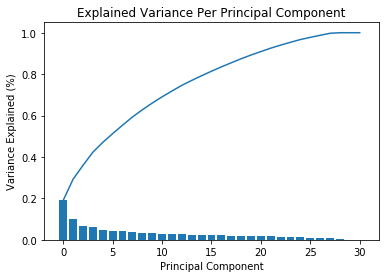

In [37]:
# Scree plot to see how many components we might use
import matplotlib.pyplot as plt

ind = np.arange(len(pca.explained_variance_ratio_))
vals = pca.explained_variance_ratio_

plt.bar(ind, vals)
plt.plot(ind, np.cumsum(vals))

plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component');

In [38]:
# Well that doesn't look promising...
# I'm not sure this will work, but let's just try it

# Add the top 2 principal components to train and test
df['pc1'] = principal_components[0]
df['pc2'] = principal_components[1]
train = df[df['created'] < cutoff]
test = df[df['created'] >= cutoff]

# Check correlation
df.corr()['price'].tail()

interest_value   -0.203596
pets_allowed      0.050989
num_features      0.309362
pc1               0.361486
pc2               0.017167
Name: price, dtype: float64

In [39]:
# So pc1 might be good, but pc2 doesn't seem to help
features = ['pc1', 'pc2']
run_linear_regression(train, test, 'price', features)

Training scores:
	Mean squared error: 2704837.06
	Mean absolute error: 1109.52
	R squared score: 0.13

Testing scores:
	Mean squared error: 2689817.57
	Mean absolute error: 1097.52
	R squared score: 0.13


In [40]:
# adding pc1 improved this test MAE by .1!  wow
features = ['bathrooms', 'bedrooms', 'num_features', 'longitude', 
            'interest_value', 'doorman', 'laundry_in_unit', 'pc1']
run_linear_regression(train, test, 'price', features)

Training scores:
	Mean squared error: 1159415.88
	Mean absolute error: 681.61
	R squared score: 0.63

Testing scores:
	Mean squared error: 1132247.13
	Mean absolute error: 685.85
	R squared score: 0.64


In [41]:
# Yesterday, I used a loop to try all the features in order of correlation.
# Try that again now

all_features = (df.corr()['price']            # get correlation of each column
                .abs()                        # get absolute value of that
                .drop('price')                # drop price's correlation to itself
                .sort_values(ascending=False) # sort descending
                .reset_index()['index'])      # get the column names themselves

y_train = train['price']
y_true = test['price']
errors = []
for n in range(1,len(all_features)+1):
  # set up the first n features
  features = all_features[:n]
  X_train = train[features]

  # fit the model
  model.fit(X_train, y_train)

  # test the model
  y_pred = model.predict(test[features])
  mea = mean_absolute_error(y_true, y_pred)
  errors.append(mea) # save errors for the alternate visualization

# plot results
import plotly.express as px
px.bar(x=all_features, y=errors, range_y=[670,900])

In [42]:
# So this is the lowest going by that method (top n correlated features)
features = ['bathrooms', 'bedrooms', 'pc1', 'num_features', 'doorman',
            'laundry_in_unit', 'longitude', 'dining_room', 'fitness_center', 
            'dishwasher', 'elevator', 'interest_value', 'terrace', 
            'outdoor_space', 'balcony', 'swimming_pool', 'no_fee', 'roof_deck', 
            'garden_patio', 'hardwood_floors', 'high_speed_internet', 
            'wheelchair_access', 'new_construction']
run_linear_regression(train, test, 'price', features)

Training scores:
	Mean squared error: 1134402.10
	Mean absolute error: 673.67
	R squared score: 0.63

Testing scores:
	Mean squared error: 1103024.60
	Mean absolute error: 676.48
	R squared score: 0.65


In [49]:
# Best score I could find by removing some
features = ['bathrooms', 'bedrooms', 'pc1', 'num_features', 'doorman',
            'laundry_in_unit', 'longitude', 'fitness_center', 
            'dishwasher', 'elevator', 'interest_value', 
            'outdoor_space', 'roof_deck', 'new_construction',
            'hardwood_floors', 'high_speed_internet']
run_linear_regression(train, test, 'price', features)

Training scores:
	Mean squared error: 1142036.59
	Mean absolute error: 671.66
	R squared score: 0.63

Testing scores:
	Mean squared error: 1108863.25
	Mean absolute error: 674.72
	R squared score: 0.64


In [64]:
# Narrowed down to 9 features without increasing error too much
features = ['bathrooms', 'bedrooms', 'doorman',
            'laundry_in_unit', 'longitude',
            'elevator', 'interest_value', 
            'hardwood_floors', 'high_speed_internet']
run_linear_regression(train, test, 'price', features)

Training scores:
	Mean squared error: 1148387.99
	Mean absolute error: 674.73
	R squared score: 0.63

Testing scores:
	Mean squared error: 1118114.51
	Mean absolute error: 678.19
	R squared score: 0.64
